First, we load all necessary depdencies.

In [1]:
#%% dependencies
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt

# ML and AI
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.activation import LeakyReLU
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.optimizers import Adam

# extra 
from tqdm import tqdm
import sys
sys.path.append('..')

# LRP
from LSTM import *


2023-07-14 10:20:41.855289: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 10:20:41.954477: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 10:20:41.955974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 10:20:43.456224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data Preparation 

In [2]:
# read in factor data as pd.dataframe
factors = pd.read_csv("../data/F-F_Research_Data_Factors.CSV", delimiter=",", skiprows=3, nrows=1163)

# rename the Date column
factors.rename(columns={factors.columns[0]: 'Date'}, inplace=True)

# convert Date column to datetime object with pandas
factors["Date"] = pd.to_datetime(factors["Date"],format="%Y%m")


# Download stock data for Apple (AAPL)
aapl = yf.download('AAPL', start='1990-01-01', end='2023-06-01')

# Download stock data for the SP500 etf SPX
sp500 = yf.download('^SPX', start='1990-01-01', end='2023-06-01')

# Resample to monthly frequency and calculate monthly returns
aapl = aapl["Adj Close"].resample('M').last().pct_change().reset_index()
sp500 = sp500["Adj Close"].resample('M').last().pct_change().reset_index()


# Merge the AAPL Series and the factors DataFrame based on the index
aapl_with_factors = pd.merge(aapl, factors[['Mkt-RF', 'SMB', 'HML']], left_index=True, right_index=True, how='left')

# Set the index back to the original date index
aapl = aapl_with_factors.set_index('Date')

# Merge the SP500 Series and the factors DataFrame based on the index
sp500_with_factors = pd.merge(sp500, factors[['Mkt-RF', 'SMB', 'HML']], left_index=True, right_index=True, how='left')

# Set the index back to the original date index
sp500 = sp500_with_factors.set_index('Date')

aapl.rename(columns={"Adj Close": "Return"}, inplace=True)
sp500.rename(columns={"Adj Close": "Return"}, inplace=True)

# clean up
del sp500_with_factors, aapl_with_factors


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
sp500

,Return,Mkt-RF,SMB,HML
Date,,,,
1990-01-31,NaN,2.96,-2.56,-2.43
1990-02-28,0.008539,2.64,-1.17,3.82
1990-03-31,0.024255,0.36,-1.40,0.13
1990-04-30,-0.026887,-3.24,-0.09,0.70
1990-05-31,0.091989,2.53,-0.10,-0.51
...,...,...,...,...
2023-01-31,0.061753,3.17,-0.30,0.23
2023-02-28,-0.026112,-1.39,-0.76,0.44
2023-03-31,0.035052,-4.80,-0.09,0.55


# Pre-Processing

After the data preperation is done, we can continue with

* splitting the data into train and test set

* scaling the data to ensure that all variables (predictor and response) are on the same scale

* re-shaping the data into a time series format that is suitable for the `tensorflow` LSTM network interface


## Window Generator by Tensorflow

In [13]:
# import linear regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# define the data to train on
data = sp500

# Drop rows with NaN values introduced by shifting
data.dropna(inplace=True)

# split into train and test
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

class WindowGenerator:
    

    def __init__(self, input_width, label_width, shift,
               train_df=train_data, val_df=test_data, test_df=test_data,
               label_columns=None):

        
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
    
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift


        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, 1:]  # Exclude the "Return" feature
        labels = features[:, self.labels_slice, 0]  # Use only the "Return" feature as labels
        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=1
        )
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

# Define the window size and create the WindowGenerator object
window_size = 5
w1 = WindowGenerator(input_width=window_size, label_width=1, shift=1, train_df=train_data)

w1.make_dataset(train_data)

# Create the input-output pairs using the WindowGenerator object
#batches = []
#for i in range(len(train_data) - w1.total_window_size):
#    batches.append(np.array(train_data.iloc[i:i + w1.total_window_size, :]))
#batches = np.stack(batches)
#
#example_inputs, example_labels = w1.split_window(batches)
#
#print('All shapes are: (batch, time, features)')
#print(f'Window shape: {batches.shape}')
#print(f'Inputs shape: {example_inputs.shape}')
#print(f'Labels shape: {example_labels.shape}')



<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None))>

## Without Window Generator

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# define the data to train on
data = sp500

# Drop rows with NaN values introduced by shifting
data.dropna(inplace=True)



# Define X, y
X = data.drop(columns="Return").values
y = data["Return"].values

# ToDo: Normalise the Features and Response 

# Define the window size for one batch of data 
window_size = 5

# Create input sequences and response
sequences = []
response  = []

for i in range(window_size, len(X)):
    sequences.append(X[i-window_size:i])
    response.append(y[i])

# Convert the lists to numpy arrays
sequences = np.array(sequences)
labels = np.array(response)

# Double check if batches were created correctly
#print(sequences[0])
#print(X[:window_size])

split_ratio = 1

split_index = int(split_ratio * len(sequences))

X_train = sequences[:split_index]
y_train = labels[:split_index]
X_test = sequences[split_index:]
y_test = labels[split_index:]



In [43]:

#%%
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras.backend as K
import tensorflow as tf
from numpy import newaxis as na
import tensorflow as tf

#%%


# Define custom 
class CustomLSTM(tf.keras.layers.LSTM):
    def __init__(self, units, **kwargs):
        super().__init__(units, **kwargs)

    def build(self, input_shape):
        super().build(input_shape)
        # Custom build logic if needed

    def call(self, inputs, **kwargs):
        # Custom call logic if needed
        return super().call(inputs, **kwargs)
    
    def get_lstm_states(self, input_data):
        """computes a forward pass through the lstm layer

        Args:
            input_data (array): (batch_size, timesteps, dimensions)
        """
    
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        # Get the LSTM weights and biases
        W = self.get_weights()[0]  # LSTM weights (D, 4M) - 4 because of 4 gates
        w_i, w_f, w_c, w_o = tf.split(W, num_or_size_splits=4, axis=1)

        H = self.get_weights()[1]  # Recurrent weights (M, 4M)
        H_i, H_f, H_c, H_o = tf.split(H, num_or_size_splits=4, axis=1)

        b = self.get_weights()[2]  # Biases (4M,)
        b_i, b_f, b_c, b_o = tf.split(b, num_or_size_splits=4, axis=0)

        # Get the number of timesteps and hidden units
        self.timesteps = input_data.shape[1]
        print("timesteps", timesteps)
        hidden_units = self.units

        # Initialize lists to store the hidden states and cell states
        self.hidden_states = []
        self.cell_states = []

        # Initialise list to store activations of gates (sigmoid) and signals (tanh)
        self.input_gate_activation = []
        self.forget_gate_activation = []
        self.output_gate_activation = []
        self.cell_input_signal = []
        self.cell_state_signal = []

        # Initialize the initial hidden state and cell state as zeros
        h_prev = np.zeros((1, hidden_units))
        c_prev = np.zeros((1, hidden_units))

        # Perform forward pass for each timestep
        for t in range(self.timesteps):
            # Get the input at the current timestep
            
            x = input_data[:, t, :]
            
            # Compute activations for the forget gate
            forget_gate_activation = np.dot(x, w_f) + np.dot(h_prev, H_f) + b_f
            forget_gate_activation = sigmoid(forget_gate_activation)

            # Compute activations for the output gate
            output_gate_activation = np.dot(x, w_o) + np.dot(h_prev, H_o) + b_o
            output_gate_activation = sigmoid(output_gate_activation)

            # Compute activations for the input gate
            input_gate_activation = np.dot(x, w_i) + np.dot(h_prev, H_i) + b_i
            input_gate_activation = sigmoid(input_gate_activation)

            # Compute signals using the tanh activation function

            # Compute signal for the cell input (part of the input gate)
            cell_input_signal = np.dot(x, w_c) + np.dot(h_prev, H_c) + b_c
            cell_input_signal = np.tanh(cell_input_signal)


            # Update the cell state
            c_new = forget_gate_activation * c_prev + input_gate_activation * cell_input_signal

            # Compute the cell state signal
            cell_state_signal = np.tanh(c_new)

            # Update hidden state 
            h_new = cell_state_signal * output_gate_activation
            
            # Append the current states to the lists
            self.hidden_states.append(np.array(h_new)) # (time_steps, batch_size, dimensions )
            self.cell_states.append(np.array(c_new)) # (time_steps, batch_size, dimensions )
            
            # Append activations
            
            self.input_gate_activation.append( np.array(input_gate_activation) )  # (time_steps, batch_size, dimensions )
            self.forget_gate_activation.append( np.array(forget_gate_activation) ) # (time_steps, batch_size, dimensions )
            self.output_gate_activation.append( np.array(output_gate_activation) ) # (time_steps, batch_size, dimensions )
            self.cell_input_signal.append( np.array(cell_input_signal) ) # (time_steps, batch_size, dimensions )
            self.cell_state_signal.append( np.array(cell_state_signal) ) # (time_steps, batch_size, dimensions )

    def lstm_lrp_rudder(self, input_data, rel_prev, aggregate=True):
        """_summary_

        Args:
            input_data (array): (batch_size, timesteps, dimensions)
            rel_prev (array): relevance is initialised by this value.

        Returns:
            array: relevance score for this lstm layer
        
        
        source: https://arxiv.org/pdf/1806.07857.pdf
        """
        
        # compute all activations (gates and signals for lstm layer)
        self.get_lstm_states(input_data)
        
        # the output of an LSTM layer with return_sequence=True must be handled -> 
        # if return_sequence=True then rel_prev.shape = (timestpes, M)
        # we can either take option 1) the last relevance scores in the sequence
        #                    option 2) aggreagte the relevance scores of the sequence
        
        
        print("lstm_lrp_rudder - aggregate: ",aggregate)
        
        if len(rel_prev.shape) == 2 and aggregate:
            print("DO AGGREGATE")
            rel_prev = np.mean(rel_prev, axis=0)
            
        elif len(rel_prev.shape) == 2 and not aggregate:
            print("DO NOT AGGREGATE")
            rel_prev = rel_prev[-1, :]
            
        
        
        # initialise relevance
        RyT = rel_prev # (M, )  M...output dim of current layer
        
        # Get the LSTM weights and biases
        W = self.get_weights()[0]  # LSTM weights (D, 4M) - 4 because of 4 gates
        w_i, w_f, w_c, w_o = tf.split(W, num_or_size_splits=4, axis=1) # (D,M), (D,M), (D,M), (D,M)
        
        # Get the LSTM weights and biases
        b = self.get_weights()[2]  # Biases (4M,)
        b_i, b_f, b_c, b_o = tf.split(b, num_or_size_splits=4, axis=0) # (M,), (M,), (M,), (M,)
    
        # Extract the last cell state
        cT = np.array(self.cell_states)[-1, 0, :] # (timesteps, batch_size, dimensions) -> (dimensions, )

        
        # Collect relevance scores
        relevance = []

        for t in reversed(range(self.timesteps)): 
            
            
            # rules according to Rudder
            zt = np.array(self.cell_input_signal)[t, 0, :] # (timesteps, batch_size, dimensions) -> (dimensions,)
            it = np.array(self.input_gate_activation)[t, 0, :] # (timesteps, batch_size, dimensions) -> (dimensions,)
            
            
            Rzt =  (zt * it) * RyT / cT
            
            # for debugging
            #print("zt.shape",zt.shape)
            #print("it.shape", it.shape)
            #print("cT.shape", cT.shape)
            #print("RyT.shape", RyT.shape)
            #print("Rzt.shape", Rzt.shape)
            
            
            # using linear rule
            relevance.append(lrp_linear(np.array(w_c), np.array(b_c), input_data[0, t, :], zt, Rzt, 3))
        
        
        print("LRP LSTM - DONE")
        return np.array(relevance)



# Define your model class
class LSTMModel(tf.keras.Model):
    
    def __init__(self):
        super(LSTMModel, self).__init__()
        
        lstm_units = 50
        input_dim = 3
        timesteps = 5
        
        # set return_state = True to return the last state in addition to the output. Default: False. 
        self.lstm1 = CustomLSTM(units=lstm_units, input_shape=(timesteps, input_dim),
                                          return_sequences=True, return_state=True)
        self.lstm2 = CustomLSTM(units=25, return_sequences=False, return_state=True)
        self.dense1 = tf.keras.layers.Dense(8)
        self.dense2 = tf.keras.layers.Dense(1)  # Output layer
        
    def call(self, inputs):
        
        
        # LSTM
        lstm1_output, hidden_state1, cell_state1 = self.lstm1(inputs)
        lstm2_output, hidden_state2, cell_state2 = self.lstm2(lstm1_output)
        
        # Dense
        dense1_output = self.dense1(lstm2_output)
    
        
        # Apply dense2 layer for final output
        output = self.dense2(dense1_output)
        
        
        # append all activation of the forward pass to dictionary
        self.activations = [{"output": lstm1_output,
                        "hidden_state": hidden_state1,
                        "cell_state": cell_state1},
                    {"output": lstm2_output,
                        "hidden_state": hidden_state2,
                        "cell_state": cell_state2},
                    {"output": dense1_output},
                    {"output": output}]
        
        # final output
        return output
    
    
    def get_activations(self):
        """Return the activations after the last forward pass."""
        
        
        new_list = []
        
        for dic in self.activations:
            
            new_dic = {}
            
            for key, item in dic:
                new_dic["key"] = item.numpy()
                
            new_list.append(new_dic)
        
        return new_list
    
    def backpropagate_relevance(self, input_data, aggregate):
    
        # feedforward
        out = self(input_data)
        
        # get prediction and initialise relevance scores
        Rj = out.numpy()[0]
        
        # Iterate through each layer in reverse order
        for i in reversed(range(len(self.layers))):
            
            # get the current layer and the lower layer
            current_layer = self.layers[i]
            lower_layer   = self.layers[i-1]
            
            # print info
            if i >0:
                print("Backpropagating Rel for Layer", current_layer, "to", lower_layer)
            
            # linear to linear
            if isinstance(current_layer, tf.keras.layers.Dense): 
                
                # get the number of output-nodes in the lower layer
                num_nodes_in_lower_layer = self.activations[i-1]["output"].numpy().shape[1] #  (batch_size, timesteps, D) -> (D, )
            
                
                w = current_layer.get_weights()[0] # get the weights for the last layer
                b = current_layer.get_weights()[1] # get the biases for the last layer
                
                

                # if last layer -> inititalise zj with the final prediction
                if (i == len(self.layers) - 1): 
                    zj = Rj 
                else:
                    zj = self.activations[i]["output"].numpy()[0,:] # shape (M, )
                
                # compute the activations in the lower layer
                zi = self.activations[i-1]["output"].numpy()[0,:] # shape (D, )
                
                # compute by relevance of layer by linear rule
                Rj = lrp_linear(w, b, zi, zj, Rj, num_nodes_in_lower_layer)
                
            elif isinstance(current_layer, tf.keras.layers.LSTM):
                
                #print(self.activations[i-1]["output"].shape)
                
                if i == 0:
                    Rj = current_layer.lstm_lrp_rudder(input_data, Rj, aggregate)
                else:
                
                    input_tmp = self.activations[i-1]["output"].numpy()

                    print("aggregate:", aggregate)
                    Rj = current_layer.lstm_lrp_rudder(input_tmp, Rj, aggregate)

            print("Rj.shape", Rj.shape)
                
        return Rj

    

def lrp_linear(w, b, z_i, z_j, Rj, nlower, eps=1e-4, delta=0.0):
    """
    LRP for a linear layer with input (previous layer) dim D and output (next layer) dim M.
    Args:
    
    w:   weights from layer i (lower) to j (higher) - array of shape (D, M)
    b:   biases  from layer i (lower) to j (higher) - array of shape (M, )
    z_i: linear activation of node i in lower layer - array of shape (D, )
    z_j: linear activation of node j in upper layer - array of shape (M, )
    Rj:  relevance score of node j from upper layer - array of shape (M, )
    nlower: the number of nodes in the lower layer  - this will be 
    eps: correction error for stabilisation i.e. to avoid cases like 0/0
    delta: set to 1.0 to check global relevance conservation, otherwise use 0.0 to ignore bias/stabilizer redistribution (recommended)
    
    Returns:
    
    Ri: relevance score for lower layer node - array of shape (D, )
    
    '''
    @author: Leila Arras
    @maintainer: Leila Arras
    @date: 21.06.2017
    @version: 1.0+
    @copyright: Copyright (c) 2017, Leila Arras, Gregoire Montavon, Klaus-Robert Mueller, Wojciech Samek
    @license: see LICENSE file in repository root
    '''
    """
    
    sign_out = np.where(z_j[na,:]>=0, 1., -1.) # shape (1, M)
    
    # define the numerator
    numer = (w * z_i[:,na]) + ( delta * (b[na,:] + eps * sign_out ) / nlower ) # shape (D, M)
    
    # Note: here we multiply the bias_factor with both the bias b and the stabilizer eps since in fact
    # using the term (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units in the numerator is only useful for sanity check
    # (in the initial paper version we were using (bias_factor*b[na,:]*1. + eps*sign_out*1.) / bias_nb_units instead)
    
    denom = z_j[na,:] + (eps*sign_out*1.)   # shape (1, M)
    
    message = (numer/denom) * Rj[na,:]       # shape (D, M)
    
    Rin = message.sum(axis=1)              # shape (D,)

    return Rin


# Define the model
model = LSTMModel()
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


# Train the model
#model.fit(X_train, y_train, epochs=10, batch_size=32)

# In order to predict a single step, i.e. only 1 batch of observations one needs to reshape (timesteps, D) -> (1, timesteps, D)
# Note we assume batch_size = 1 -> it simplified the implementation of the custom LSTM model class
#print(np.expand_dims(X_train[0], axis=0).shape)

#model.predict(np.expand_dims(X_train[0], axis=0))


In [42]:
batch_size = 1  # Number of samples in a batch
timesteps = 5  # Number of time steps
input_dim = 3  # Dimensionality of each input

input_data = np.random.rand(batch_size, timesteps, input_dim) # sample input
# ---------------------------------------------------------------------------------------------

out = model(input_data)
out2 = model.predict(input_data)


model.activations[0]["output"].numpy()

model.backpropagate_relevance(input_data, False)
# Create a Keras backend function
#backend_fn = tf.keras.backend.function(inputs=[model.input], outputs=model.activations)

# Call the backend function to get the output values
#out = backend_fn(input_data)



1/1 [==============================] - 0s 33ms/step
Backpropagating Rel for Layer <keras.layers.core.dense.Dense object at 0x7f2b8f276690> to <keras.layers.core.dense.Dense object at 0x7f2b8f1e4610>
Rj.shape (8,)
Backpropagating Rel for Layer <keras.layers.core.dense.Dense object at 0x7f2b8f1e4610> to <__main__.CustomLSTM object at 0x7f2b8ec877d0>
Rj.shape (25,)
Backpropagating Rel for Layer <__main__.CustomLSTM object at 0x7f2b8ec877d0> to <__main__.CustomLSTM object at 0x7f2b8efd0410>
aggregate: False
timesteps 5
lstm_lrp_rudder - aggregate:  False
LRP LSTM - DONE
Rj.shape (5, 50)
timesteps 5
lstm_lrp_rudder - aggregate:  False
DO NOT AGGREGATE
LRP LSTM - DONE
Rj.shape (5, 3)


array([[-0.04260502, -0.11332803,  0.21691612],
       [-0.36862262, -0.01699621,  0.0650334 ],
       [-0.15892914, -0.03429435,  0.0461774 ],
       [-0.35166868, -0.07162303,  0.12717289],
       [-0.04738249, -0.01304704,  0.01813685]])

## Rolling Regression with LSTM model

In [44]:
# Define the window size to train the model on
big_window_size = 60

# Define the size of the validation set for the rolling window
validation_size = 1 / 60

# Calculate the number of rolling windows and the size of the validation set
num_windows = len(X_train) - window_size 
validation_set_size = int(num_windows * validation_size)

predictions = []

for i in tqdm(range(num_windows)):
    start_index = i
    end_index = i + window_size

    X_train_window = X_train[start_index:end_index]
    y_train_window = y_train[start_index:end_index]

    # Create a validation set from a portion of the rolling window
    X_val = X_train[end_index : end_index + validation_set_size]
    y_val = y_train[end_index : end_index + validation_set_size]

    # Train the model on the current rolling window
    model.fit(X_train_window,
              y_train_window,
              validation_data=(X_val, y_val),
              epochs=10,
              batch_size=32,
              verbose=False)

    # Predict the next timestep
    X_next = X_train[end_index:end_index + 1]  # Get the last observation in the validation set
    
    next_pred = model.predict(X_next, verbose=False)  # Predict the next timestep based on X_next
    predictions.append(next_pred)
    
predictions =  np.array(predictions)[:, 0, 0]



  0%|          | 0/390 [00:00<?, ?it/s]

2023-07-14 11:02:08.390755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-14 11:02:08.393311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-14 11:02:08.395199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

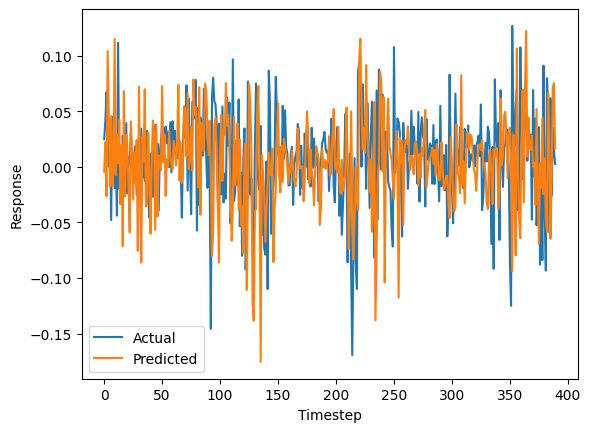

In [45]:
plt.plot(y_train[window_size:], label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Timestep')
plt.ylabel('Response')
plt.legend()
plt.show()
